In [42]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader, natural_earth
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as mticker
import cmocean
from utils import move_last_two_months_first
import matplotlib.patches as mpatches

def make_example_storm_outputs_figure(mean_decadal_counts):

    output = move_last_two_months_first(mean_decadal_counts)
    
    month_strings = ["November", "December", "January", "February", "March", "April"]

    fig, axes = plt.subplots(5, 6, figsize=(20,15), layout="compressed", subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

    # Add transparent land by creating a custom feature
    land_shp = natural_earth(resolution='110m', category='physical', name='land')
    land_feature = ShapelyFeature(Reader(land_shp).geometries(),
                                  ccrs.PlateCarree(), facecolor='lightgray', edgecolor='face', alpha=0.5)
    # Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
    
    # Add countries boundaries and labels
    countries_shp = natural_earth(resolution='50m', category='cultural', name='admin_0_countries')
    countries_feature = ShapelyFeature(Reader(countries_shp).geometries(), ccrs.PlateCarree(),
                                       facecolor='none', edgecolor='black', linewidth=1, alpha=1)

    pc = np.empty((5, 6), dtype=object)
    for category in range(1, 6):
        for month in range(6):
            
            ax = axes[category - 1, month]
            ax.add_feature(land_feature)
            ax.add_feature(countries_feature)
            ax.add_feature(states_provinces, edgecolor='gray')

            ax.set_xticks([])
            ax.set_yticks([])

            val = np.flipud(output[:, :, month, category])
            # Plot gradient for model prediction on top of the land feature
            lonplot2 = np.linspace(135, 240, val.shape[1])
            latplot2 = np.linspace(-5, -60, val.shape[0])
            
            # Use a continuous colormap
            pc[category-1][month] = ax.contourf(lonplot2, latplot2, val, levels=100, cmap=cmocean.cm.matter, transform=ccrs.PlateCarree())
            
            gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                              linewidth=1, color='white', alpha=0.3, linestyle='--')
            gl.top_labels = False
            gl.right_labels = False
            ax.set_extent([135, 240, -60, -5], crs=ccrs.PlateCarree())

    for month in range(6):
        ax = axes[0, month]
        ax.set_title(month_strings[month], pad=15)
        # Add gridlines with labels
        
        
        gl.xlocator = mticker.FixedLocator([-180, -160, -140, -90, -45, 0, 45, 90, 140, 160, 180, 225, 270, 315, 360])
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 18, 'color': 'black'}
        gl.ylabel_style = {'size': 18, 'color': 'black'}
            
        # Adjust map extent to focus on the region of interest
    
    for category in range(1, 6):
        ax = axes[category - 1, 0]
        ax.set_ylabel(f"Category {category}", rotation=0, ha='right', labelpad=50)
        
        fig.colorbar(pc[category-1][2], ax=axes[category-1, :])
    
    #fig.subplots_adjust(right=0.8)
    #cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    plt.show()
    
def load_example_mean_decadal_count(data_folder):
    files = glob.glob(os.path.join(data_folder, "*.hdf5"))
    if len(files) < 1:
        return
        
    with h5py.File(files[0], 'r+') as file:
        grid = file['train_grids'][0]
        print(np.array(grid).shape)
        print(np.max(grid))
        grid = np.array(grid[-1])
        print(np.count_nonzero(grid))
        print(np.max(np.sum(grid, axis=-2)))
        return grid


(10, 110, 210, 6, 6)
1.4
523010
4.16


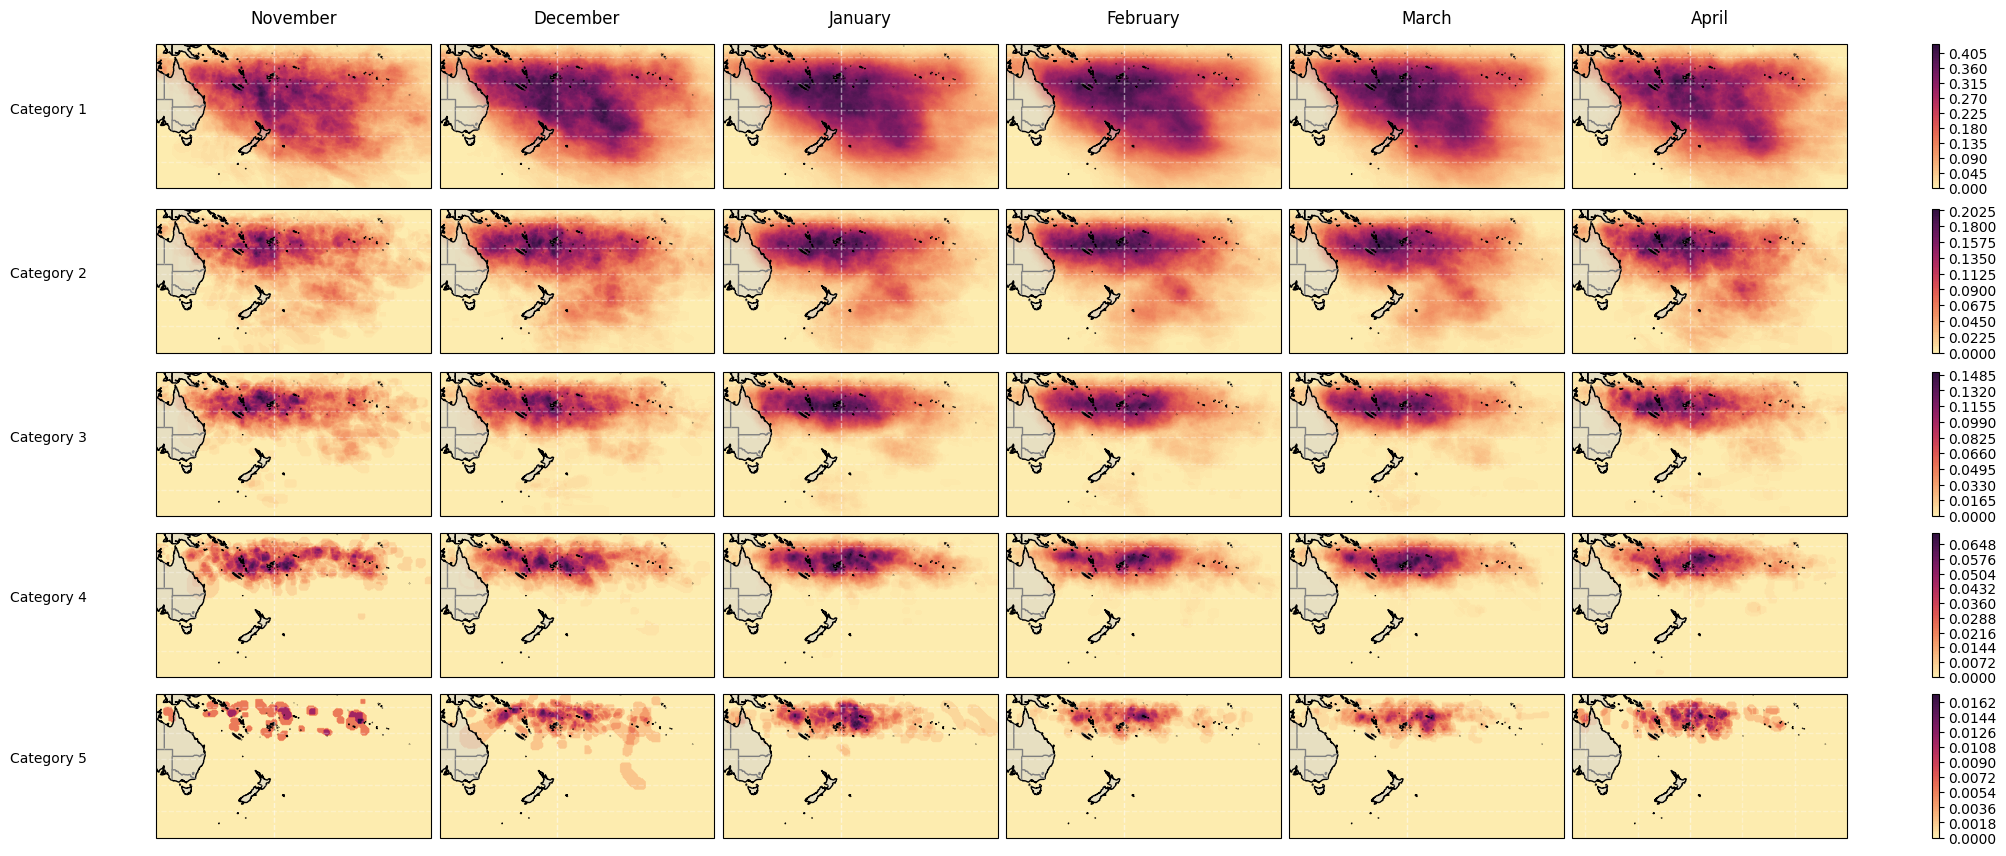

In [3]:
data_folder  = "/users/ewinkelm/data/ewinkelm/"

mean_decadal_count = load_example_mean_decadal_count(data_folder)

make_example_storm_outputs_figure(mean_decadal_count)

In [43]:
import sys
sys.path.append('../')

In [47]:
import os
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader, natural_earth
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as mticker
import cmocean
from MachineLearning.Evaluation.model_statistics import kolmogorov_smirnov_statistics
from HealthFacilities.getHealthFacilityData import Sites
from MachineLearning.Evaluation.evaluation_utils import get_site_values

In [45]:

font_size = 24
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['axes.labelsize'] = font_size
plt.rcParams['axes.titlesize'] = font_size
plt.rcParams['xtick.labelsize'] = font_size
plt.rcParams['ytick.labelsize'] = font_size
plt.rcParams['legend.fontsize'] = font_size
plt.rcParams['legend.title_fontsize'] = font_size


def model_statistic_maps(statistics, save_path=None, vmin=0, vmax=1):
    """
    Outputs a map of the KS statistic
    """
    
    # Add transparent land by creating a custom feature
    land_shp = natural_earth(resolution='110m', category='physical', name='land')
    land_feature = ShapelyFeature(Reader(land_shp).geometries(), ccrs.PlateCarree(), facecolor='lightgray', edgecolor='face', alpha=0.5)
    # Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
    
    # Add countries boundaries and labels
    countries_shp = natural_earth(resolution='50m', category='cultural', name='admin_0_countries')
    countries_feature = ShapelyFeature(Reader(countries_shp).geometries(), ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, alpha=1)
    print(statistics.keys())
    n_models = len(statistics.keys())
    print(n_models)
    fig, axes = plt.subplots(1, n_models, figsize=(20,15), layout="compressed",  subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

    model_n = 0
    
    max_val = np.max([list(outputs) for outputs in all_outputs.values()])
    
    for model, statistic in statistics.items():
        
        ax = axes[model_n]

        ax.add_feature(land_feature)
        ax.add_feature(countries_feature)
        #ax.add_feature(states_provinces, edgecolor='gray')
        ax.set_xticks([])
        ax.set_yticks([])
            
        val = statistic
            
        # Plot gradient for model prediction on top of the land feature
        lonplot2 = np.linspace(135, 240, val.shape[1])
        latplot2 = np.linspace(-5, -60, val.shape[0])

            
        # Use a continuous colormap
        contour = ax.contourf(lonplot2, latplot2, val, levels=100, cmap=cmocean.cm.matter, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
            
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                              linewidth=1, color='white', alpha=0.3, linestyle='--', zorder=0)
        gl.top_labels = False
        gl.right_labels = False

        ax.set_extent([135, 240, -60, -5], crs=ccrs.PlateCarree())

        # add a patch over the pacific islands region
        #150, 185, -23, -5
        xy = [150, -23]
        width = 40 
        height = 18
        
        ax.add_patch(mpatches.Rectangle(xy=xy, width=width, height=height,
                                facecolor='none', edgecolor='g',
                                transform=ccrs.PlateCarree(), zorder=10, linewidth=3))
        
        model_n += 1

    for model_idx, model in enumerate(statistics.keys()):
        
        model_title = model
        if model == "DDPM UNet": model_title = "UNet"
        elif model == "DDPM UNet N=100 Decades": model_title = "UNet N=100 Decades"
        elif model == "Nearest Neighbors Regressor": model_title = "Nearest Neighbors"
            
        ax = axes[model_idx]
        ax.xlabel_style = {'size': 30, 'color': 'black'}
        ax.set_xlabel(model_title, rotation=0)
        
    
    cb = fig.colorbar(contour, ax=axes, fraction=0.046, pad=0.005)
    tick_locator = mticker.MaxNLocator(nbins=6)
    cb.locator = tick_locator
    
    cb.update_ticks()
    if save_path is not None:
        plt.savefig(save_path)
        plt.clf()
    else: 
        plt.show()
    

In [48]:
all_outputs = np.load("/Users/eliwinkelman/Downloads/all_predictions_out_of_domain.npy", allow_pickle=True)[()]

ks_statistics = {}
mean_site_ks = {}
ground_truths = all_outputs.pop("STORM")

for model, outputs in all_outputs.items():
    ks_statistics[model] = kolmogorov_smirnov_statistics(ground_truths, outputs)
    mean_site_ks[model] = np.mean(get_site_values(ks_statistics[model]))


/Users/eliwinkelman/code/EMPIRIC-AI-emulation/ml_env/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:394: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  return hypotest_fun_in(*args, **kwds)


In [49]:
print(mean_site_ks)

{'Nearest Neighbors Regressor': 0.3006603223926976, 'FNO': 0.3119829093027772, 'DDPM UNet': 0.3191105068945426, 'DDPM UNet N=100 Decades': 0.4165469023111284, 'FNO N=100 Decades': 0.47304330938046213}


In [54]:
all_outputs = np.load("/Users/eliwinkelman/Downloads/all_predictions_in_domain.npy", allow_pickle=True)[()]

ks_statistics_in_domain = {}
mean_site_ks_in_domain = {}
max_site_ks_in_domain = {}
min_site_ks_in_domain = {}
ground_truths = all_outputs.pop("STORM")

for model, outputs in all_outputs.items():
    ks_statistics_in_domain[model] = kolmogorov_smirnov_statistics(ground_truths, outputs)
    mean_site_ks_in_domain[model] = np.mean(get_site_values(ks_statistics_in_domain[model]))
    max_site_ks_in_domain[model] = np.max(get_site_values(ks_statistics_in_domain[model]))
    min_site_ks_in_domain[model] = np.min(get_site_values(ks_statistics_in_domain[model]))

    

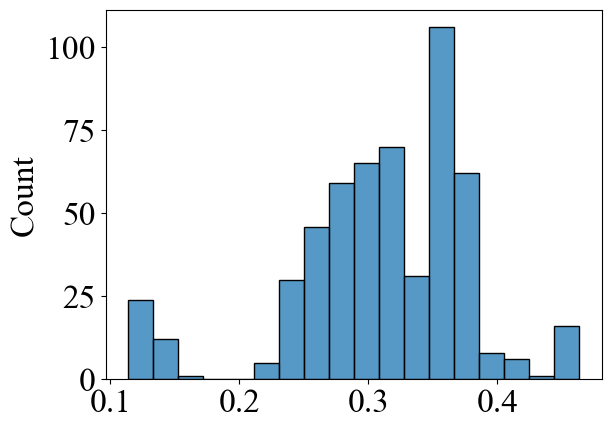

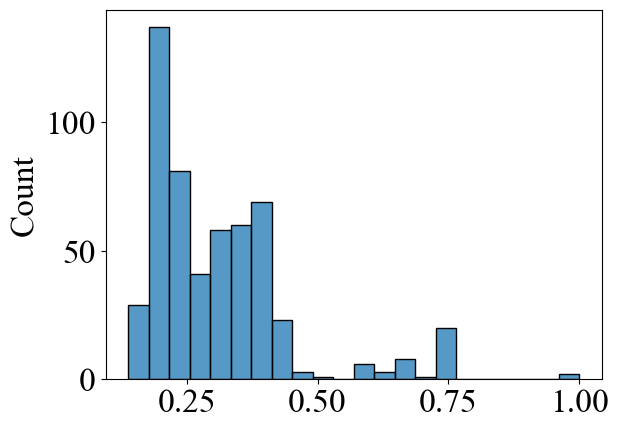

<Axes: ylabel='Count'>

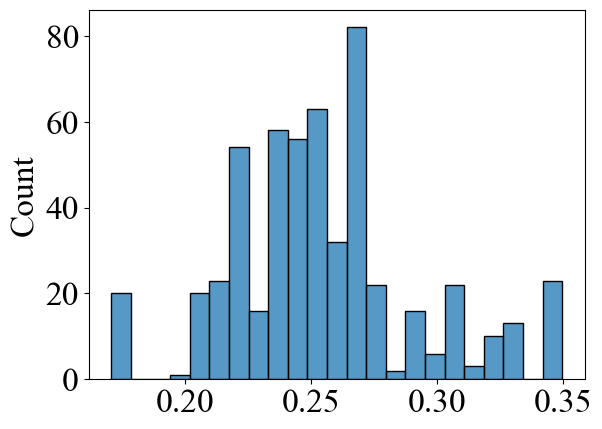

In [61]:
import seaborn as sns

sns.histplot(get_site_values(ks_statistics_in_domain["FNO"]))
plt.show()
sns.histplot(get_site_values(ks_statistics_in_domain["DDPM UNet"]))
plt.show()
sns.histplot(get_site_values(ks_statistics_in_domain["Nearest Neighbors Regressor"]))

dict_keys(['Nearest Neighbors Regressor', 'FNO', 'DDPM UNet', 'DDPM UNet N=100 Decades', 'FNO N=100 Decades'])
5


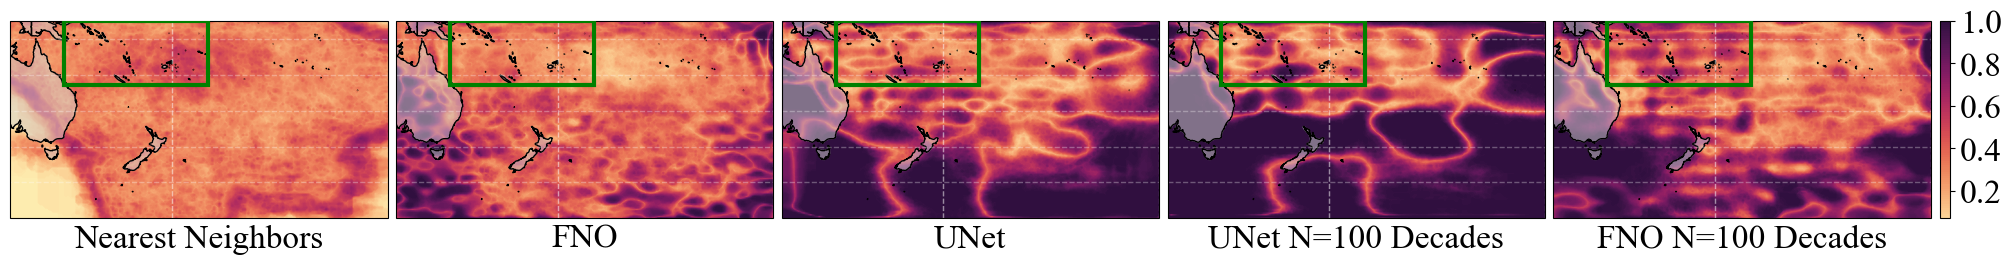

In [41]:
model_statistic_maps(ks_statistics)

In [19]:
all_outputs = np.load("/Users/eliwinkelman/Downloads/all_predictions_out_of_domain.npy", allow_pickle=True)[()]

ks_statistics_difference = {}
ground_truths = all_outputs.pop("STORM")

for model, outputs in all_outputs.items():
    mean = np.mean(outputs, axis=0)
    ks_statistics_out_of_domain = kolmogorov_smirnov_statistics(ground_truths, outputs)
    ks_statistics_difference[model] = (ks_statistics_out_of_domain - ks_statistics[model]) / (mean+1)
    


/Users/eliwinkelman/code/EMPIRIC-AI-emulation/ml_env/lib/python3.11/site-packages/scipy/stats/_stats_py.py:9081: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  return ks_2samp(xvals, yvals, alternative=alternative, method=method)


dict_keys(['Nearest Neighbors Regressor', 'FNO', 'DDPM UNet', 'DDPM UNet N=100 Decades', 'FNO N=100 Decades'])
5


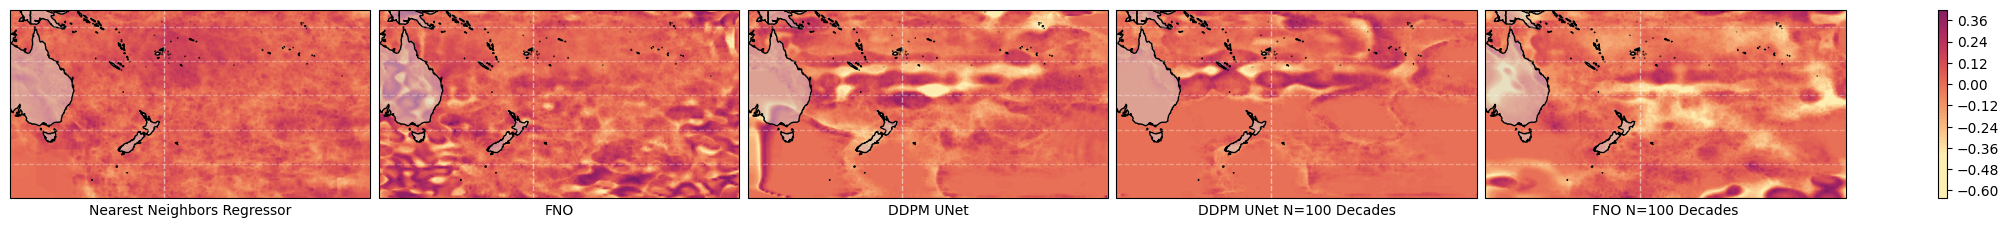

In [20]:
model_statistic_maps(ks_statistics_difference, vmin=-0.4, vmax=0.7)

In [50]:
all_outputs_out_of_domain = np.load("/Users/eliwinkelman/Downloads/all_predictions_out_of_domain.npy", allow_pickle=True)[()]

means = {}
variances = {}

for model, outputs in all_outputs_out_of_domain.items():
    means[model] = np.mean(outputs, axis=0)
    variances[model] = np.var(outputs, axis=0)


STORM_mean = means.pop("STORM")
for key in means.keys():
    means[key] = np.abs(STORM_mean - means[key])
    
STORM_variance = variances.pop("STORM")
for key in variances.keys():
    variances[key] = STORM_variance - variances[key]


dict_keys(['Nearest Neighbors Regressor', 'FNO', 'DDPM UNet', 'DDPM UNet N=100 Decades', 'FNO N=100 Decades'])
5


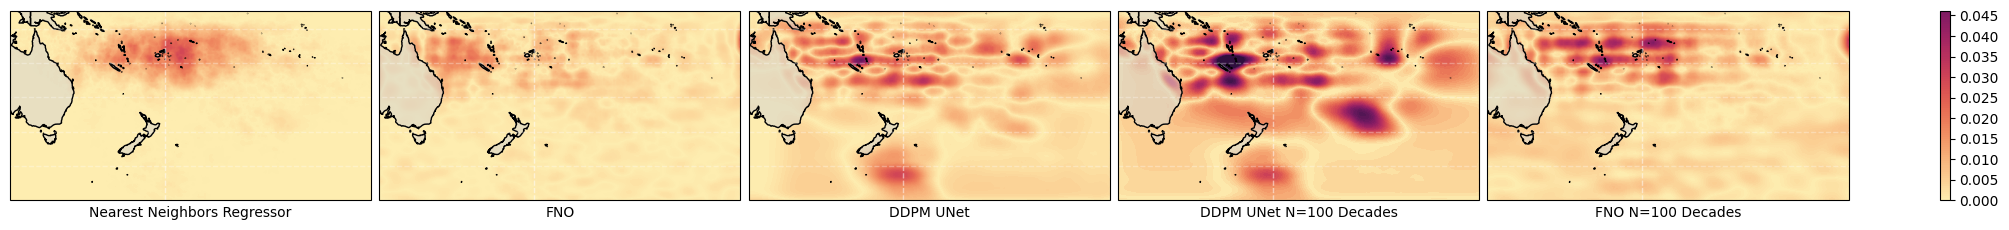

In [51]:
model_statistic_maps(means, vmin=0, vmax=0.06)

dict_keys(['Nearest Neighbors Regressor', 'FNO', 'DDPM UNet', 'DDPM UNet N=100 Decades', 'FNO N=100 Decades'])
5


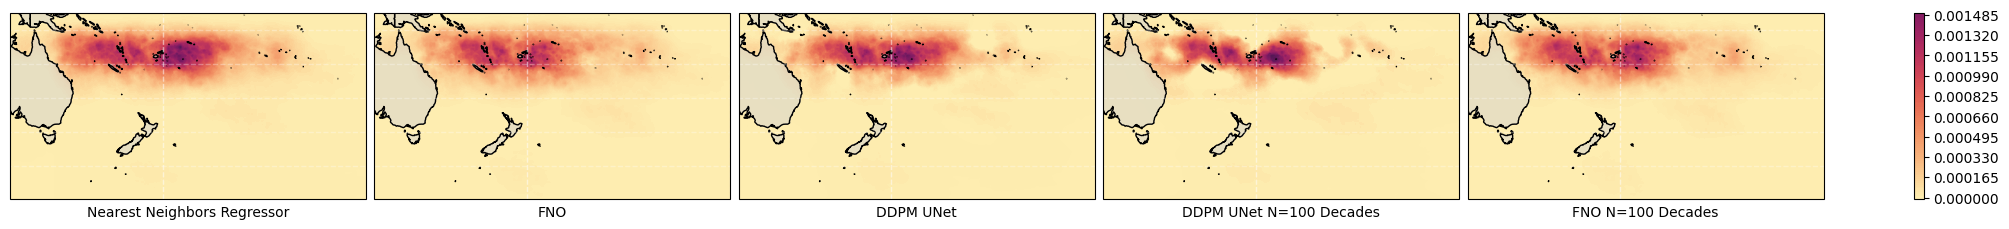

In [42]:
model_statistic_maps(variances, vmin=0, vmax=0.002)

In [52]:
all_outputs = np.load("/Users/eliwinkelman/Downloads/all_predictions.npy", allow_pickle=True)[()]

means = {}
variances = {}
for model, outputs in all_outputs.items():
    means[model] = np.mean(outputs, axis=0)
    variances[model] = np.var(outputs, axis=0)

STORM_mean = means.pop("STORM")
for key in means.keys():
    means[key] = np.abs(STORM_mean - means[key])
    
STORM_variance = variances.pop("STORM")
for key in variances.keys():
    variances[key] = STORM_variance - variances[key]


dict_keys(['Nearest Neighbors Regressor', 'FNO', 'DDPM UNet', 'DDPM UNet N=100 Decades', 'FNO N=100 Decades'])
5


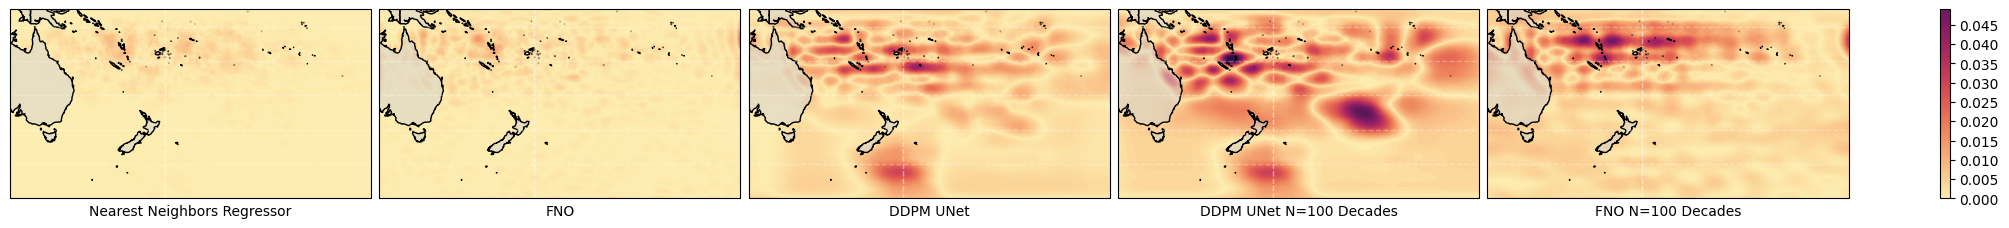

In [53]:
model_statistic_maps(means, vmin=0, vmax=0.06)

dict_keys(['Nearest Neighbors Regressor', 'FNO', 'DDPM UNet', 'DDPM UNet N=100 Decades', 'FNO N=100 Decades'])
5


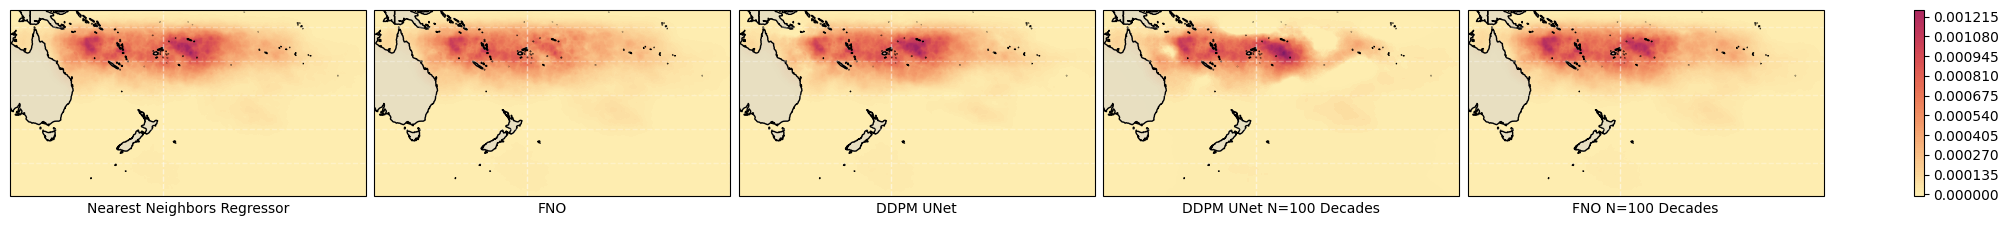

In [54]:
model_statistic_maps(variances, vmin=0, vmax=0.002)

In [2]:
import os
import glob
print(os.getcwd())

/oscar/home/ewinkelm/EMPIRIC_AI_emulation/notebooks


In [4]:
files = glob.glob(os.path.join("../../data/ewinkelm", "*.hdf5"))

In [11]:
import h5py
with h5py.File(files[0], "r") as file:
    geneses = file["train_grids"]
    print(geneses[:,9].shape)

IndexError: Index (10) out of range for (0-9)

In [17]:
import numpy as np
a = [1, 2, 3]
a[0, 2]

TypeError: list indices must be integers or slices, not tuple